# Train and Evaluate Models for Chocolate Targets

This notebook demonstrates how to load formulation data, ensure target columns are present (by running the estimator if necessary), train Random Forest and Gradient Boosting models for each target, evaluate, save models and metrics, and visualize results.

In [1]:
# Setup imports and paths
from pathlib import Path
import sys, os, json, warnings
import numpy as np
import pandas as pd
import ast
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from importlib.machinery import SourceFileLoader
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, accuracy_score, f1_score, roc_auc_score, confusion_matrix

ROOT = Path('..')
DATA_DIR = ROOT / 'data'
PROCESS_SRC = ROOT / 'src' / 'process' / '2. Chocolate_target_estimation.py'
INPUT_CSV = DATA_DIR / 'Chocolate_bar_dataset_with_features.csv'
OUTPUTS = ROOT / 'outputs'
MODELS_DIR = OUTPUTS / 'models'
OUTPUTS.mkdir(parents=True, exist_ok=True)
MODELS_DIR.mkdir(parents=True, exist_ok=True)
print('Paths set. INPUT:', INPUT_CSV, 'PROCESS_SRC:', PROCESS_SRC)

Paths set. INPUT: ..\data\Chocolate_bar_dataset_with_features.csv PROCESS_SRC: ..\src\process\2. Chocolate_target_estimation.py


## Extract `target_columns` from the process script
We parse the Python source file to find the literal `target_columns` list used by the estimator.

In [2]:
def extract_target_columns(source_path: Path):
    src = source_path.read_text(encoding='utf-8')
    tree = ast.parse(src)
    for node in ast.walk(tree):
        if isinstance(node, ast.Assign):
            for t in node.targets:
                if isinstance(t, ast.Name) and t.id == 'target_columns':
                    return ast.literal_eval(node.value)
    raise RuntimeError('target_columns not found in process source')

target_columns = extract_target_columns(PROCESS_SRC)
print('Found', len(target_columns), 'target columns')
print(target_columns)

Found 24 target columns
['hardness_newtons', 'snap_force_newtons', 'viscosity_pas', 'particle_size_d50_micron', 'color_l_value', 'color_a_value', 'color_b_value', 'gloss_units', 'sweetness_score', 'bitterness_score', 'creaminess_score', 'overall_flavor_balance', 'texture_liking', 'overall_preference', 'fat_bloom_severity', 'sugar_bloom_severity', 'color_delta_e', 'hardness_change_pct', 'peroxide_value', 'free_fatty_acids', 'water_activity', 'moisture_content_pct', 'overall_acceptability', 'shelf_life_exceeded']


## Load dataset and synthesize targets if missing
If the input CSV doesn't already include the target columns, we will import `estimate_chocolate_targets` from the process script and run it to create target columns.

In [3]:
if not INPUT_CSV.exists():
    raise FileNotFoundError(f'Input CSV not found: {INPUT_CSV}')
df = pd.read_csv(INPUT_CSV)
print('Loaded data shape:', df.shape)
missing = [t for t in target_columns if t not in df.columns]
if missing:
    print('Missing targets:', missing)
    mod = SourceFileLoader('estimator', str(PROCESS_SRC)).load_module()
    if not hasattr(mod, 'estimate_chocolate_targets'):
        raise RuntimeError('estimate_chocolate_targets not found in process source')
    print('Running estimator to generate targets...')
    df = mod.estimate_chocolate_targets(df)
    out_csv = OUTPUTS / 'complete_formulations_with_targets.csv'
    df.to_csv(out_csv, index=False)
    print('Saved enhanced CSV to', out_csv)
else:
    print('All targets present in input CSV.')

Loaded data shape: (107, 91)
Missing targets: ['particle_size_d50_micron']
Running estimator to generate targets...
Estimating target values based on scientific correlations...
1. Estimating physical properties...
2. Estimating color properties...
3. Estimating sensory properties...
4. Estimating stability properties...
5. Rounding values for measurement realism...
6. Generating summary statistics...

Target Value Ranges (Estimated):
--------------------------------------------------
hardness_newtons          |  31.60 -  48.00 | Mean:  45.12
snap_force_newtons        |  23.80 -  28.00 | Mean:  27.80
viscosity_pas             |   1.50 -   8.66 | Mean:   6.08
particle_size_d50_micron  |  12.60 -  20.40 | Mean:  16.27
color_l_value             |  25.80 -  53.40 | Mean:  42.36
color_a_value             |   9.20 -  14.20 | Mean:  11.70
color_b_value             |  15.70 -  29.90 | Mean:  22.87
gloss_units               |  93.20 -  95.00 | Mean:  94.98
sweetness_score           |   1.00 -   

## Data overview
Show a quick preview and numeric columns used for modeling.

In [4]:
display(df.head())
print('Dtypes:')
print(df.dtypes.value_counts())
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print('Numeric columns count:', len(numeric_cols))
print('Sample numeric columns:', numeric_cols[:20])

,FormulaID,Flavor,is_classic_milk,is_fruit_flavor,cocoa_beans,cocoa_butter,palm_oil,whole_milk_powder,beetroot_sugar,soy_lecithin,...,sugar_bloom_severity,color_delta_e,hardness_change_pct,peroxide_value,free_fatty_acids,water_activity,moisture_content_pct,overall_acceptability,shelf_life_exceeded,particle_size_d50_micron
0,form-000000001,Classic Milk Original,1,0,15,29,0.0,15.65,40.00,0.3,...,1,2.40,9.4,1.80,3.069,0.553,1.29,4.5,1,16.9
1,form-000000002,Mango Original,0,1,15,29,0.0,40.00,15.65,0.3,...,2,4.01,18.9,3.39,3.447,0.583,2.07,4.3,1,14.8
2,form-000000003,Cherry Original,0,1,15,29,0.0,40.00,15.65,0.3,...,3,3.27,19.2,4.39,4.000,0.587,2.30,3.0,1,19.2
3,form-000000004,Blackberry Original,0,1,15,29,0.0,40.00,15.65,0.3,...,2,3.51,18.8,5.01,2.992,0.589,2.09,3.5,1,14.5
4,form-000000005,Strawberry Original,0,1,15,29,0.0,40.00,15.65,0.3,...,2,3.73,18.1,2.72,2.378,0.575,2.41,2.9,1,14.2


Dtypes:
float64    77
int64      13
object      2
Name: count, dtype: int64
Numeric columns count: 90
Sample numeric columns: ['is_classic_milk', 'is_fruit_flavor', 'cocoa_beans', 'cocoa_butter', 'palm_oil', 'whole_milk_powder', 'beetroot_sugar', 'soy_lecithin', 'artificial_vanilla_aroma', 'natural_vanilla_aroma', 'natural_flavor', 'Energy_kcal', 'protein', 'fat', 'SFA', 'carbohydrates', 'Total_sugars', 'Salt', 'total_cocoa_pct', 'milk_sugar_ratio']


## Prepare features and targets
We use numeric columns and drop the target columns from the feature matrix.

In [5]:
targets_present = [t for t in target_columns if t in df.columns]
if not targets_present:
    raise RuntimeError('No targets available to train on')
numeric = df.select_dtypes(include=[np.number]).copy()
X = numeric.drop(columns=targets_present, errors='ignore')
Y = df[targets_present].copy()
print('X shape:', X.shape)
print('Y shape:', Y.shape)

X shape: (107, 66)
Y shape: (107, 24)


## Training helper and loop
Define a helper to train per-target models (RandomForest and GradientBoosting) and collect metrics.

In [6]:
def train_for_target(X, y, target_name, models_dir, random_state=42, test_size=0.2, n_estimators=500):
    is_class = target_name == 'shelf_life_exceeded' or y.dropna().drop_duplicates().isin([0,1]).all()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y if is_class else None)
    results = {}
    preds_store = {}
    if is_class:
        models = {
            'random_forest': RandomForestClassifier(n_estimators=n_estimators, random_state=random_state),
            'grad_boost': GradientBoostingClassifier(n_estimators=n_estimators, random_state=random_state)
        }
    else:
        models = {
            'random_forest': RandomForestRegressor(n_estimators=n_estimators, random_state=random_state),
            'grad_boost': GradientBoostingRegressor(n_estimators=n_estimators, random_state=random_state)
        }
    for name, model in models.items():
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        metric = {}
        if is_class:
            metric['accuracy'] = float(accuracy_score(y_test, preds))
            metric['f1'] = float(f1_score(y_test, preds, zero_division=0))
            try:
                if hasattr(model, 'predict_proba'):
                    probs = model.predict_proba(X_test)[:,1]
                    metric['roc_auc'] = float(roc_auc_score(y_test, probs))
                else:
                    metric['roc_auc'] = None
            except Exception:
                metric['roc_auc'] = None
        else:
            metric['r2'] = float(r2_score(y_test, preds))
            metric['mae'] = float(mean_absolute_error(y_test, preds))
            metric['rmse'] = float(mean_squared_error(y_test, preds) ** 0.5)
        model_path = Path(models_dir) / f'{target_name}__{name}.joblib'
        joblib.dump(model, model_path)
        results[name] = {'model_path': str(model_path), 'metrics': metric}
        preds_store[name] = {'X_test_index': X_test.index.tolist(), 'y_test': y_test.tolist(), 'preds': [float(x) for x in preds]}
    return results, preds_store

In [ ]:
metrics = {}
artifacts = {}
for tgt in:
    print('Training target:', tgt)
    try:
        res, preds = train_for_target(X, Y[tgt], tgt, MODELS_DIR, n_estimators=100)
        metrics[tgt] = res
        artifacts[tgt] = preds
    except Exception as e:
        warnings.warn(f'Failed for {tgt}: {e}')

# Create a DataFrame summarizing metrics
rows = []
for tgt, model_info in metrics.items():
    for mname, info in model_info.items():
        row = {'target': tgt, 'model': mname}
        row.update(info['metrics'])
        row['model_path'] = info['model_path']
        rows.append(row)
metrics_df = pd.DataFrame(rows)
display(metrics_df)

Training target: hardness_newtons


Training target: snap_force_newtons
Training target: viscosity_pas
Training target: particle_size_d50_micron
Training target: color_l_value
Training target: color_a_value
Training target: color_b_value
Training target: gloss_units
Training target: sweetness_score
Training target: bitterness_score
Training target: creaminess_score
Training target: overall_flavor_balance
Training target: texture_liking
Training target: overall_preference
Training target: fat_bloom_severity
Training target: sugar_bloom_severity
Training target: color_delta_e
Training target: hardness_change_pct
Training target: peroxide_value
Training target: free_fatty_acids
Training target: water_activity
Training target: moisture_content_pct
Training target: overall_acceptability
Training target: shelf_life_exceeded


C:\Users\mji11\AppData\Local\Temp\ipykernel_50116\1978120302.py:10: UserWarning: Failed for shelf_life_exceeded: y contains 1 class after sample_weight trimmed classes with zero weights, while a minimum of 2 classes are required.
  warnings.warn(f'Failed for {tgt}: {e}')


,target,model,r2,mae,rmse,model_path
0,hardness_newtons,random_forest,0.281631,1.908726e+00,2.425275e+00,..\outputs\models\hardness_newtons__random_for...
1,hardness_newtons,grad_boost,0.167390,1.990351e+00,2.611006e+00,..\outputs\models\hardness_newtons__grad_boost...
2,snap_force_newtons,random_forest,-4.463510,1.961468e-01,2.921286e-01,..\outputs\models\snap_force_newtons__random_f...
3,snap_force_newtons,grad_boost,-7.200995,2.318797e-01,3.579081e-01,..\outputs\models\snap_force_newtons__grad_boo...
4,viscosity_pas,random_forest,-0.822243,5.753990e-01,7.170656e-01,..\outputs\models\viscosity_pas__random_forest...
5,viscosity_pas,grad_boost,-0.995740,6.356402e-01,7.504257e-01,..\outputs\models\viscosity_pas__grad_boost.jo...
6,particle_size_d50_micron,random_forest,-0.586804,1.327425e+00,1.621170e+00,..\outputs\models\particle_size_d50_micron__ra...
7,particle_size_d50_micron,grad_boost,-0.736436,1.379114e+00,1.695885e+00,..\outputs\models\particle_size_d50_micron__gr...
8,color_l_value,random_forest,0.825165,1.149217e+00,1.415238e+00,..\outputs\models\color_l_value__random_forest...
9,color_l_value,grad_boost,0.828640,1.079926e+00,1.401102e+00,..\outputs\models\color_l_value__grad_boost.jo...


## Visualize example targets
Plot a regression true vs predicted and classification confusion matrix where applicable.

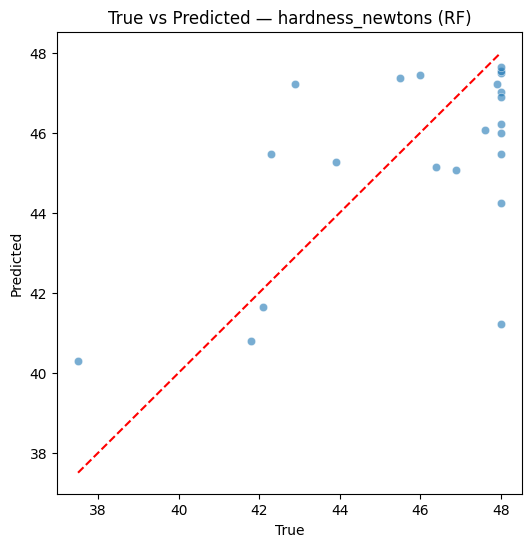

No shelf_life_exceeded results available


In [8]:
# Regression visualization
reg = None
for t in targets_present:
    if t != 'shelf_life_exceeded':
        reg = t
        break
if reg and reg in metrics:
    mpath = metrics[reg]['random_forest']['model_path']
    model = joblib.load(mpath)
    X_tr, X_te, y_tr, y_te = train_test_split(X, Y[reg], test_size=0.2, random_state=42)
    preds = model.predict(X_te)
    plt.figure(figsize=(6,6))
    sns.scatterplot(x=y_te, y=preds, alpha=0.6)
    plt.plot([y_te.min(), y_te.max()], [y_te.min(), y_te.max()], 'r--')
    plt.xlabel('True')
    plt.ylabel('Predicted')
    plt.title(f'True vs Predicted — {reg} (RF)')
    plt.show()
else:
    print('No regression target available for plot')

# Classification visualization
if 'shelf_life_exceeded' in metrics:
    mpath = metrics['shelf_life_exceeded']['random_forest']['model_path']
    clf = joblib.load(mpath)
    X_tr, X_te, y_tr, y_te = train_test_split(X, Y['shelf_life_exceeded'], test_size=0.2, random_state=42, stratify=Y['shelf_life_exceeded'])
    preds = clf.predict(X_te)
    cm = confusion_matrix(y_te, preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix — shelf_life_exceeded (RF)')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
else:
    print('No shelf_life_exceeded results available')

In [9]:
# Save metrics and artifacts
metrics_out = OUTPUTS / 'metrics_summary.json'
metrics_out.write_text(json.dumps(metrics, indent=2))
print('Wrote metrics to', metrics_out)
print('Saved model files:')
for p in sorted(MODELS_DIR.rglob('*.joblib')):
    print('-', p)

Wrote metrics to ..\outputs\metrics_summary.json
Saved model files:
- ..\outputs\models\bitterness_score__grad_boost.joblib
- ..\outputs\models\bitterness_score__random_forest.joblib
- ..\outputs\models\color_a_value__grad_boost.joblib
- ..\outputs\models\color_a_value__random_forest.joblib
- ..\outputs\models\color_b_value__grad_boost.joblib
- ..\outputs\models\color_b_value__random_forest.joblib
- ..\outputs\models\color_delta_e__grad_boost.joblib
- ..\outputs\models\color_delta_e__random_forest.joblib
- ..\outputs\models\color_l_value__grad_boost.joblib
- ..\outputs\models\color_l_value__random_forest.joblib
- ..\outputs\models\creaminess_score__grad_boost.joblib
- ..\outputs\models\creaminess_score__random_forest.joblib
- ..\outputs\models\fat_bloom_severity__grad_boost.joblib
- ..\outputs\models\fat_bloom_severity__random_forest.joblib
- ..\outputs\models\free_fatty_acids__grad_boost.joblib
- ..\outputs\models\free_fatty_acids__random_forest.joblib
- ..\outputs\models\gloss_units_